In [11]:
# NG implementation for Linear advection with a standard Gaussian bump
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
from flax import linen as nn
import optax
import matplotlib.pyplot as plt

x = jnp.linspace(-3.0,3.0, 5000)
x = x.reshape(-1, 1) 
T = 4.0 #end time
#c = 1.0 #constat speed
c= lambda t: jnp.sin(t)

targets=jnp.exp(-0.5*x**2)/jnp.sqrt(2*jnp.pi) 

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(25)(x)
        x = nn.relu(x)
        x = nn.Dense(25)(x)
        x = nn.relu(x)
        x = nn.Dense(25)(x)
        x = nn.relu(x)
        x = nn.Dense(25)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x
    
rng = random.PRNGKey(0)
rng, key = random.split(rng)
model = MLP()
params = model.init(key, x)['params']



epoch:0 loss: 1.8297556607649312e-06
epoch:1 loss: 0.0003419414279051125
epoch:2 loss: 1.2248294751771027e-06
epoch:3 loss: 3.5138713428750634e-05
epoch:4 loss: 1.497156063123839e-05
epoch:5 loss: 4.835088475374505e-05
epoch:6 loss: 3.1024363124743104e-05
epoch:7 loss: 5.572108784690499e-05
epoch:8 loss: 2.0179433704470284e-05
epoch:9 loss: 4.468623046705034e-06
epoch:10 loss: 6.386852078321681e-07
epoch:11 loss: 3.6670676308858674e-06
epoch:12 loss: 1.0020639820140786e-05
epoch:13 loss: 1.1051060937461443e-05
epoch:14 loss: 9.297470569435973e-06
epoch:15 loss: 2.1971012756694108e-05
epoch:16 loss: 2.0819108613068238e-05
epoch:17 loss: 1.8814109353115782e-05
epoch:18 loss: 2.209691228927113e-05
epoch:19 loss: 1.9863775378325954e-05
epoch:20 loss: 2.081255297525786e-05
epoch:21 loss: 1.374669409415219e-05
epoch:22 loss: 1.7708924133330584e-05
epoch:23 loss: 1.7222449969267473e-05
epoch:24 loss: 7.019974418653874e-06
epoch:25 loss: 1.0665227819117717e-05
epoch:26 loss: 8.002474714885466e

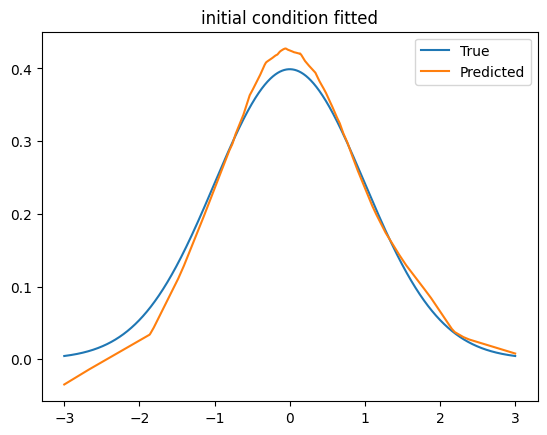

In [12]:
# Enforce the initial condition using ADAM to adjust the initial parameters
optimizer = optax.adam(learning_rate= 5e-4 ,nesterov=False)
opt_state = optimizer.init(params)

#training step
@jit
def train_step(params, opt_state, inputs, targets):
    def mse(params, inputs, targets):
        predictions = model.apply({'params': params}, inputs)
        return jnp.mean((predictions - targets) ** 2)
    
    loss, grads = jax.value_and_grad(mse)(params, inputs, targets)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, opt_state

epochs=100
bs=32
losses = []
for epoch in range(epochs):
    for i in range(0, len(x), bs):
        x_batch = x[i:i+bs]
        targets_batch = targets[i:i+bs]
        loss, params, opt_state = train_step(params, opt_state, x_batch, targets_batch)
    losses.append(loss)
    print(f"epoch:{epoch} loss: {loss}")
    # if epoch%20==0: #check relative loss
    #     if check_rel_error(params)<0.01:
    #          break 
#check the initial condition fitted
#plot a loss curve
# plt.figure()
# plt.plot(losses)
# plt.title('Loss curve')
# plt.yscale('log')
# plt.show()    


plt.figure()
plt.plot(x, targets, label='True')
plt.plot(x, model.apply({'params':params}, x), label='Predicted')
plt.title('initial condition fitted')
plt.legend()
plt.show()


In [13]:
# store params for debugging

params_store=params

In [14]:
#recover trained params
params=params_store

In [24]:
# ##### don't use this! by GPT4
# #### 
# x=jnp.linspace(-3.0,3.0, 1000).reshape(-1, 1)

# def theta_update(params, input):
#     def model_output(params, x):
#         output=model.apply({'params': params}, x)
#         return output[0] # to make it a scalar function, otherwise output has weird shape

#     grad_fn = jit(grad(model_output, argnums=0))

#     treeshape = jax.tree_util.tree_structure(params) # record treedef of params
#     print(treeshape)

#     def flatten_grads(params, x):
#         grads = grad_fn(params, x)
#         flat_grads, _ = jax.tree_util.tree_flatten(grads)
#         return jnp.concatenate([jnp.ravel(g) for g in flat_grads])

#     batch_flatten_grads = vmap(flatten_grads, in_axes=(None, 0))

#     flat_gradients = batch_flatten_grads(params, x)
#     print(flat_gradients.shape)

#     # compute the corresponding predicted values at sampled points
#     u_pred=model.apply({'params':params}, x).reshape(-1, 1)

#     #now solve least squaer
#     print(u_pred.shape)
#     dl_theta,_,_,_=jnp.linalg.lstsq(flat_gradients, u_pred, rcond=None)
#     print(len(dl_theta))
#     dl_theta = dl_theta.reshape(treeshape.num_leaves, -1)
#     print(len(dl_theta))
#     for i in range(8):
#         print(len(dl_theta[i]))
#     # Check the number of leaves in dl_theta and params
#     # print(len(jax.tree_util.tree_leaves(params)))
#     # print(len(jax.tree_util.tree_leaves(dl_theta)))
#     leaves, treedef = jax.tree_util.tree_flatten(params)
#     # Add the dl_theta vector to the flattened params
#     leaves = leaves + [dl_theta]
#     # Unflatten the updated params
#     updated_params = jax.tree_util.tree_unflatten(treedef, leaves)

#     # Print the updated params
#     print(updated_params)

#     return updated_params



In [15]:
# step to update parameters (theta)
def theta_update(params, inputs, t,dt):
    import time
    def model_output(params, x):
        output = model.apply({'params': params}, x)
        # Return a scalar value instead of an array
        return output.reshape(-1)[0]

    grad_theta = jit(jax.grad(model_output, argnums=0))
    # Record the tree structure of params
    treeshape = jax.tree_util.tree_structure(params)
    start=time.time()
    def flatten_grads(params, x):
        grads = grad_theta(params, x)
        flat_grads, _ = jax.tree_util.tree_flatten(grads)
        return jnp.concatenate([g.ravel() for g in flat_grads])
    batch_flatten_grads = vmap(flatten_grads, in_axes=(None, 0))



    # Prepare Jacobian and RHS
    J = batch_flatten_grads(params, inputs).reshape(len(inputs), -1)
    # check size
    
    Jprepared=time.time()
    grad_x = jit(jax.grad(model_output, argnums=1))
    ########################################################
    # setup RHS of the linear advection equation
    def compute_RHS(params, x,t):
        du_dx = jax.grad(model_output, argnums=1)(params, x)
        return -1 * c(t) * du_dx

    RHS_pred = vmap(compute_RHS, in_axes=(None, 0,None))(params, inputs,t ).reshape(-1, 1)
    RHSprepared=time.time()
    #RHS_pred = jnp.ones((len(inputs), 1))
    ########################################################
    del_theta, _, _, _ = jnp.linalg.lstsq(J, RHS_pred)
    #print(jnp.linalg.norm(del_theta))

    # Scale the parameter update by dt
    del_theta = del_theta * dt
    lsqsolved=time.time()
    reshaped_del_theta = []
    idx = 0
    for leaf in jax.tree_util.tree_leaves(params):
        leaf_shape = leaf.shape
        if len(leaf_shape) == 1:
            reshaped_del_theta.append(del_theta[idx:idx+leaf_shape[0]].reshape(leaf_shape))
            idx += leaf_shape[0]
        else:
            reshaped_del_theta.append(del_theta[idx:idx+leaf_shape[0]*leaf_shape[1]].reshape(leaf_shape))
            idx += leaf_shape[0]*leaf_shape[1]

    update = jax.tree_util.tree_unflatten(treeshape, reshaped_del_theta)
    new_params = jax.tree_util.tree_map(lambda p, u: p + u, params, update)
    print(f"J time: {Jprepared-start}")
    print(f"RHS time: {RHSprepared-Jprepared}")
    print(f"Lstsq time: {lsqsolved-RHSprepared}")

    return new_params

J time: 0.13904523849487305
RHS time: 0.12711191177368164
Lstsq time: 14.103945970535278
1
J time: 0.10992288589477539
RHS time: 0.01698613166809082
Lstsq time: 12.213360071182251
2
J time: 0.14972209930419922
RHS time: 0.055290937423706055
Lstsq time: 13.06534218788147
3
J time: 0.14381909370422363
RHS time: 0.049182891845703125
Lstsq time: 10.852885007858276
4
J time: 0.14076805114746094
RHS time: 0.02951812744140625
Lstsq time: 12.574602842330933
5
J time: 0.14127063751220703
RHS time: 0.03982830047607422
Lstsq time: 12.130926847457886
6
J time: 0.1633620262145996
RHS time: 0.03779888153076172
Lstsq time: 13.347910165786743
7
J time: 0.1644291877746582
RHS time: 0.05995798110961914
Lstsq time: 18.620660066604614
8
J time: 0.18882989883422852
RHS time: 0.02339625358581543
Lstsq time: 15.046736717224121
9
J time: 0.18643689155578613
RHS time: 0.02727484703063965
Lstsq time: 14.116657257080078
10


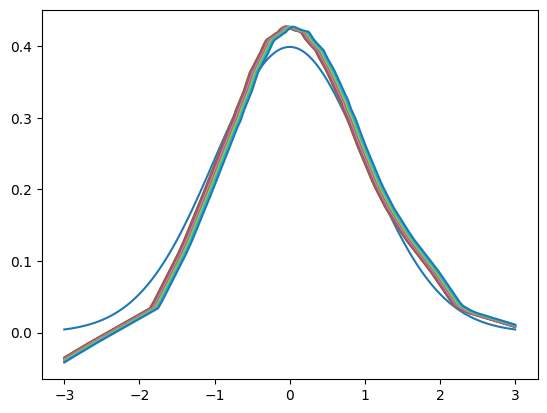

In [16]:
T=0.5
dt=0.05
N=int(T/dt)
t=0.0

# time loop
plt.figure()
plt.plot(x, targets, label='True')
u_all=[]
for i in range(N):
    # Update parameters using theta_update function
    params = theta_update(params, x, t,dt)
    u = model.apply({'params': params}, x)
    t+=dt
    u_all.append(u)
    print(len(u_all))
    plt.plot(x, u, label='Predicted')
plt.show()

    
    

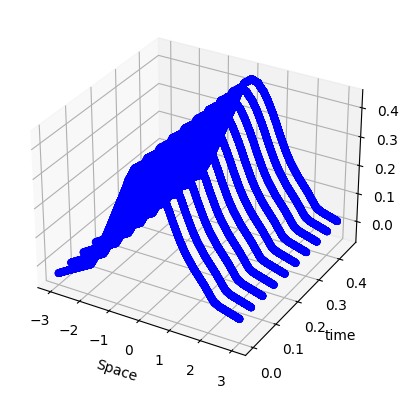

In [17]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming x is a 1D array with 5000 elements, T_values will be a 1D array with N elements
# Flatten 'x' to ensure it's a 1D array
x = x.flatten()
T_values = jnp.arange(0, T, dt)  # Generate time values

# Initialize figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, u in enumerate(u_all):
    ax.scatter(x, T_values[i] * jnp.ones_like(u), u, label=f'Time {i*dt}', color="b")

# Label the axes
ax.set_xlabel('Space')
ax.set_ylabel("time")
plt.show()
